# POC-Turtle word category learner, part 2. Singular Values.
This is a continuation of part 1 of proof-of-concept (POC) experiments in unsupervised language learning (ULL).  
The previous notebook is shared as a [static html page](http://88.99.210.144/data/clustering_2018/html/POC-Turtle-1-2018-02-09.html), code hosted on [GitHub](https://github.com/opencog/language-learning)

In [1]:
import os, sys, time, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
from src.utl.utl import UTC
from src.space.turtle import dumb_parser, parses2vec
from src.utl.turtle import save_txt_and_readme, html_table, readmes
from src.clustering.kmeans import cluster_kmeans
print(UTC(), ':: module_path:', module_path)

2018-02-17 16:37:55 UTC :: module_path: /home/oleg/language-learning


## 2.1 Looking for optimal vector space dimensionality: Singular values

In [2]:
input_file = '../data/poc-turtle-sentences.txt'
prj_dir = '../output/Turtle-2-2018-02-14/'  # project directory 
prefix = ''     # all project files will start with this prefix
verbose = 'min' # printed comments: 'none', 'min', 'max'
log = {'project': 'POC-Turtle-2: singular values'}

if not os.path.isfile(input_file):
    print('No data file', module_path + input_file[2:])
else: print('Data file found:', module_path + input_file[2:])
if not os.path.exists(prj_dir):
    os.makedirs(prj_dir)
    print('Project directory created:', module_path + prj_dir[2:])
else: print('Project directory', module_path + prj_dir[2:], 'exists')
if verbose == 'max': print(UTC(), log)
log.update({'input_file': module_path + input_file[2:]})

Data file found: /home/oleg/language-learning/data/poc-turtle-sentences.txt
Project directory /home/oleg/language-learning/output/Turtle-2-2018-02-14/ exists


### 2.1.1 Check singular values

Singular values: 5.65, 5.29, 4.95, 4.67, 4.59, 3.49, 3.45, 0.19


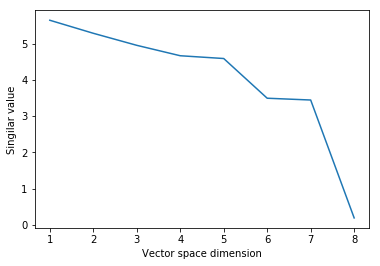

In [3]:
parses = dumb_parser(input_file, verbose)
path = module_path + prj_dir[2:]    # path to store vectors
tmpath = path # module_path + '/tmp/'  # path for temporary files
dim = 8     # Vector space dimensions
cds = 1.0   # Context distribution smoothing [default: 1.0]
eig = 0.5   # Weighted exponent of the eigenvalue matrix [default: 0.5]
neg = 1     # Number of negative samples, subtracts its log from PMI [default: 1] 
vdf,res1 = parses2vec(parses,path,tmpath,dim,cds,eig,neg,'none')
log.update(res1)
singular_values = pd.DataFrame(np.load(path+'svd.s.npy'),columns=['sv'])
singular_values.index = range(1,len(singular_values)+1)
print('Singular values:', \
      ', '.join(str(round(x,2)) for x in singular_values['sv']))
singular_values
plt.plot(singular_values.index, singular_values['sv'])
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()

SVD algorithm cannot create the 9th dimension. 
The 8th singular value is much less than the previous 7 - does it mean that 7 dimensions are enough?

### 2.1.2 Create 7-dimension word vector space

In [4]:
dim = 7
vdf,res2 = parses2vec(parses,path,tmpath,dim,cds,eig,neg,'none')
zdf = vdf.copy()
cols = zdf.columns.tolist()
del zdf['word']
def zeros(x):
    if abs(x) > 1e-10: return round(x,5)
    else: return 0
zdf = zdf.applymap(zeros)
zdf['word'] = vdf['word']
zdf = zdf[cols]
zdf.sort_values(by=[1,2], ascending=[True,True])

,word,1,2,3,4,5,6,7
8,has,-0.72861,0.00000,-0.27295,0.00000,-0.01631,0.00000,0.62798
10,isa,-0.68847,0.00000,-0.18048,0.00000,-0.43633,0.00000,-0.55051
1,.,-0.40156,0.00000,0.89628,0.00000,0.18796,0.00000,-0.00972
0,###LEFT-WALL###,-0.25778,0.00000,-0.30456,0.00000,0.88007,0.00000,-0.25741
2,bird,0.00000,0.31233,0.00000,-0.77630,0.00000,0.54754,0.00000
4,extremity,0.00000,0.31233,0.00000,-0.77630,0.00000,0.54754,0.00000
7,fish,0.00000,0.31233,0.00000,-0.77630,0.00000,0.54754,0.00000
5,feather,0.00000,0.42149,0.00000,-0.55118,0.00000,-0.72010,0.00000
12,scale,0.00000,0.42149,0.00000,-0.55118,0.00000,-0.72010,0.00000
3,eagle,0.00000,0.83496,0.00000,0.50090,0.00000,0.22790,0.00000


**Wow!**: Axis 1 and 2 have separated nouns (axis 1 ~ 0) and "not-nouns" - the group including verbs, period and ###LEFT-WALL###. Moreover, the nouns are naturally clustered along the '2' axis in 4 clusters with the same values!

### 2.1.3 Cluster words in 7-dim space with "natural" clusters
Looking at the first two columns of the previuos table (1 and 2) one can see "natural" clusters - 8 groups of words with the same values along axes 1 and 2. Let's check clustering with K-Means algoritm with the number of clusters parameter set to 8.

In [6]:
n = 8  # Number of clusters
words = vdf['word'].tolist()
df = vdf.loc[:,[1,2,3,4,5,6,7]]
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
cdf = pd.DataFrame(centroids)
def row_index(row): return int(row.name)
def cluster_word_list(row): return cluster_words[int(row.name)]
cls = cdf.applymap(zeros)
cls['cluster_words'] = cls.apply(cluster_word_list, axis=1)
cls.index = range(1,len(cls)+1)
cls['cluster'] = cls.apply(row_index, axis=1)
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col+11})
for col in cls.columns:
    if type(col) == int: cls=cls.rename(columns={col:col-10})
cls

,1,2,3,4,5,6,7,cluster_words,cluster
1,0.00000,0.42149,0.00000,-0.55118,0.00000,-0.72010,0.00000,"[feather, scale]",1
2,0.00000,0.83496,0.00000,0.50090,0.00000,0.22790,0.00000,"[eagle, herring, parrot, tuna]",2
3,0.00000,0.31233,0.00000,-0.77630,0.00000,0.54754,0.00000,"[bird, extremity, fish]",3
4,-0.72861,0.00000,-0.27295,0.00000,-0.01631,0.00000,0.62798,[has],4
5,-0.25778,0.00000,-0.30456,0.00000,0.88007,0.00000,-0.25741,[###LEFT-WALL###],5
6,-0.40156,0.00000,0.89628,0.00000,0.18796,0.00000,-0.00972,[.],6
7,-0.68847,0.00000,-0.18048,0.00000,-0.43633,0.00000,-0.55051,[isa],7
8,0.00000,0.84761,0.00000,-0.13343,0.00000,-0.51357,0.00000,"[fin, wing]",8


Clusters in vector space, axes 1 and 2


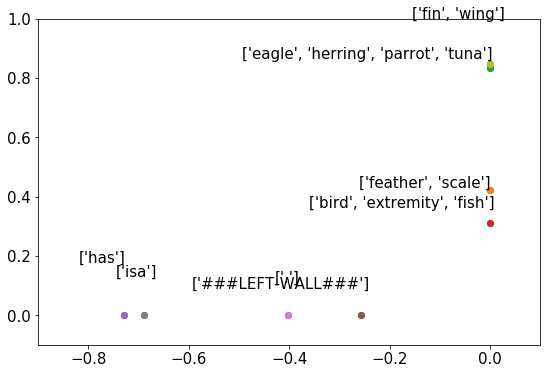

In [7]:
def plot2d(i, j, df, label='', f=15):
    if label == 'cluster_words': header = 'Clusters'
    else: header = 'Words'
    print(header, 'in vector space, axes', i, 'and', j)
    font = {'size': f}
    plt.rc('font', **font)
    plt.figure(figsize=(9,6))
    plt.scatter(df[i].values, df[j].values)
    #plt.axis('off')
    plt.xlim(round(df[i].min()-0.2,1), round(df[i].max()+0.1,1))
    plt.ylim(round(df[j].min()-0.1,1), round(df[j].max()+0.2,1))
    k = df.index.min()  # ~ 1st row index (usually 0 or 1)
    for n, wlst in enumerate(df[label]):
        x, y = df[i][n+k], df[j][n+k]
        plt.scatter(x, y)
        annot = {'has': (1, 50), 'is': (1, 5)}
        plt.annotate(wlst, xy=(x, y),
            xytext=annot.get(' '.join(w for w in wlst),(1+n*2, 6*n)), 
            textcoords='offset points', ha='right', va='bottom', )
    #plt.show()
plot2d(1,2,cls,'cluster_words',15)

**Great!** 2D word space gives quite a lot of information on word categories.  
Now let's get more from the other dimensions, plotting in 2D even and odd dimensions:

Clusters in vector space, axes 1 and 3


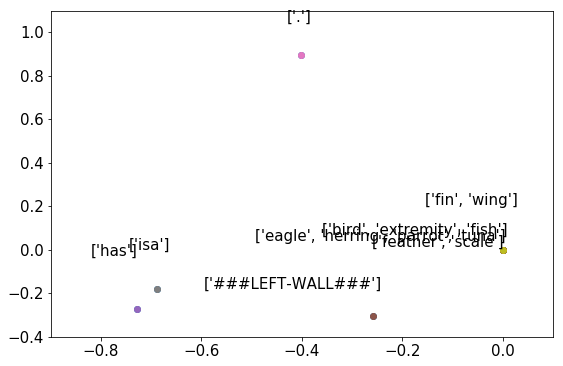

In [8]:
plot2d(1, 3, cls, 'cluster_words', 15)

Clusters in vector space, axes 2 and 4


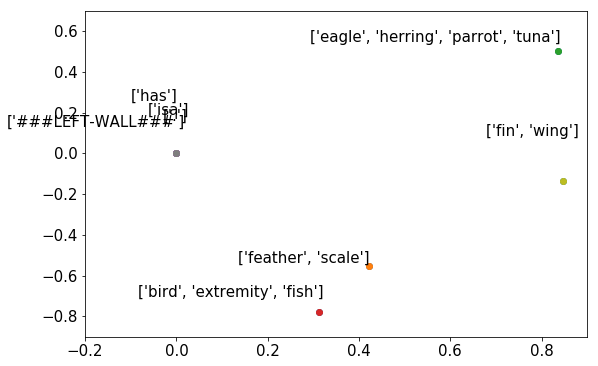

In [9]:
plot2d(2, 4, cls, 'cluster_words', 15)

## 2.2 Words in 7-dim vector space

Words in vector space, axes 1 and 2


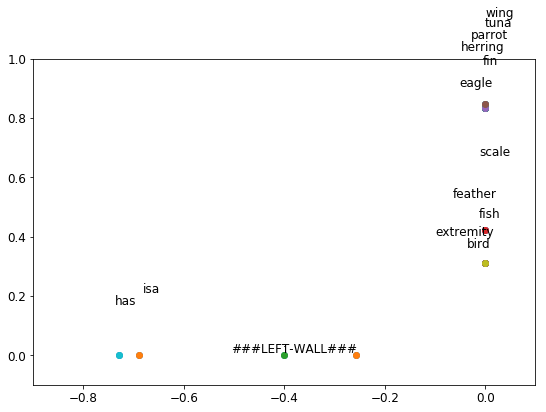

In [10]:
plot2d(1, 2, zdf, 'word', 12)

Word spacial distibution in the first two axes 2D space look the same as the cluster pattern above.

### 2.2.1 Nouns: zero even axes 

In [11]:
nouns = zdf.loc[abs(vdf[1])<1e-12].sort_values(by=[2], ascending=True).copy()
nouns.index = range(0, len(nouns))
nouns #.loc[:,['word',1,2,4,6]]

,word,1,2,3,4,5,6,7
0,bird,0.0,0.31233,0.0,-0.77630,0.0,0.54754,0.0
1,extremity,0.0,0.31233,0.0,-0.77630,0.0,0.54754,0.0
2,fish,0.0,0.31233,0.0,-0.77630,0.0,0.54754,0.0
3,feather,0.0,0.42149,0.0,-0.55118,0.0,-0.72010,0.0
4,scale,0.0,0.42149,0.0,-0.55118,0.0,-0.72010,0.0
5,eagle,0.0,0.83496,0.0,0.50090,0.0,0.22790,0.0
6,herring,0.0,0.83496,0.0,0.50090,0.0,0.22790,0.0
7,parrot,0.0,0.83496,0.0,0.50090,0.0,0.22790,0.0
8,tuna,0.0,0.83496,0.0,0.50090,0.0,0.22790,0.0
9,fin,0.0,0.84761,0.0,-0.13343,0.0,-0.51357,0.0


**Wow!** The nouns are naturally clustered: 4 clear clusters with **same** values on odd axes 2,4,6! We have seen above, that nouns are situated along the 2nd axis and can be clustered by the its value. Additional axes can help separate the nouns in space and explore similarity using cosine distance or other spacial metrics.

Words in vector space, axes 2 and 4


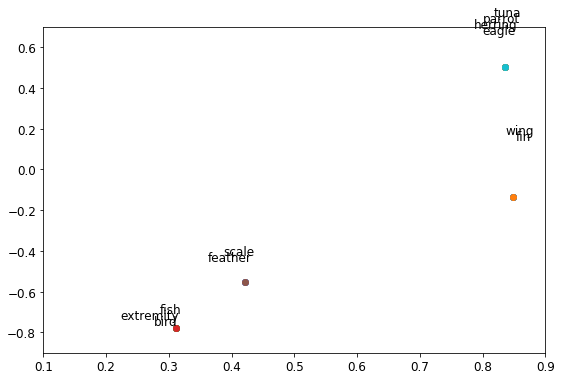

In [12]:
plot2d(2,4,nouns,'word',12)

Words in vector space, axes 4 and 6


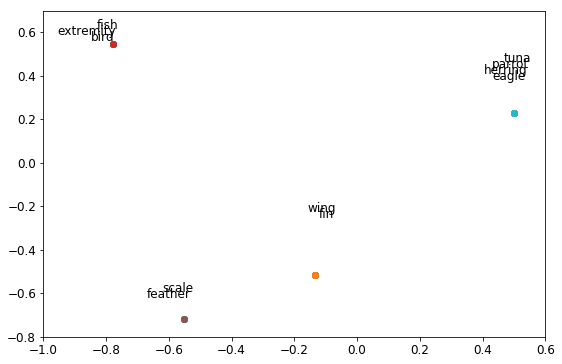

In [13]:
plot2d(4,6,nouns,'word',12)

### 2.2.2 "Not-nouns": 2 verbs, ##LEFT-WALL## and period -- non-zero even axes and zero odd axes

Words in vector space, axes 1 and 3


,word,1,2,3,4,5,6,7
0,has,-0.72861,0.0,-0.27295,0.0,-0.01631,0.0,0.62798
1,isa,-0.68847,0.0,-0.18048,0.0,-0.43633,0.0,-0.55051
2,.,-0.40156,0.0,0.89628,0.0,0.18796,0.0,-0.00972
3,###LEFT-WALL###,-0.25778,0.0,-0.30456,0.0,0.88007,0.0,-0.25741


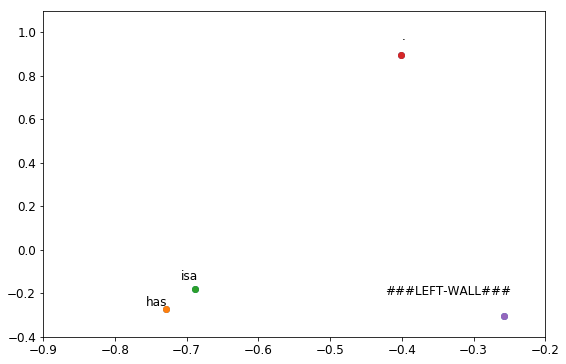

In [14]:
not_nouns = zdf.loc[abs(vdf[1])>1e-12].sort_values(by=[1], ascending=True).copy()
not_nouns.index = range(0, len(not_nouns))
plot2d(1,3,not_nouns,'word',12)
not_nouns #.loc[:,['word',1,3,5,7]]

Adding the other axe helps separate the verbs from ##Left-Wall## and period.

## 2.2 Word Category learning: clustering clusters

### 2.2.1 Optimal number of clusters: max Silhouette index

Silhouette index in a range of cluster numbers


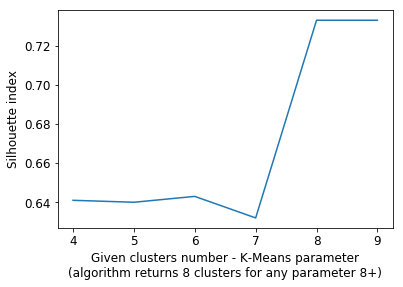

N,NR,Silhouette,Clusters
4,4,0.641,eagle herring parrot tuna | bird extremity fish | feather fin scale wing | #LW# . has isa
5,5,0.64,. | bird extremity fish | eagle herring parrot tuna | #LW# has isa | feather fin scale wing
6,6,0.643,bird extremity fish | eagle herring parrot tuna | feather fin scale wing | has isa | . | #LW#
7,7,0.632,bird extremity fish | feather fin scale wing | eagle herring parrot tuna | #LW# | has | . | isa
8,8,0.733,bird extremity fish | fin wing | eagle herring parrot tuna | has | . | #LW# | isa | feather scale
9,8,0.733,. | fin wing | eagle herring parrot tuna | bird extremity fish | has | #LW# | isa | feather scale


In [15]:
words = vdf['word'].tolist()
df = vdf.copy()
del df['word']
sil_range = pd.DataFrame(columns=['NC','NR','Silhouette','Inertia'])
sil_range['NC'] = sil_range['NC'].astype(int)
table = [['N', 'NR', 'Silhouette', 'Clusters']]
tsv = 'N\tNR\tSilhouette\tClusers\n'
for i,j in enumerate(range(4,10)):
    silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
        cluster_word_ids, cluster_words = cluster_kmeans(j, df, words)
    sil_range.loc[i] = [j, len(cluster_words), round(silhouette,3), inertia]
    table.append([j, len(cluster_words), round(silhouette,3), \
        ' | '.join(' '.join(str(word) for word in cluster)
            .replace('###LEFT-WALL###', '#LW#') for cluster in cluster_words)])
    tsv = tsv + str(j) + '\t' + str(len(cluster_words)) + '\t' + \
        str(round(silhouette,3)) + '\t' + \
        ' '.join('|'.join(str(word) for word in cluster) \
                 for cluster in cluster_words) + '\n'
sil_range[['NC','NR']] = sil_range[['NC','NR']].astype(int)

print('Silhouette index in a range of cluster numbers')
plt.plot(sil_range['NC'], sil_range['Silhouette'])
plt.xlabel('Given clusters number - K-Means parameter\n' + \
           '(algorithm returns 8 clusters for any parameter 8+)')
plt.ylabel('Silhouette index')
plt.show()
display(html_table(table))

6 - small local maximum, looks good
8 - max silhouette, looks ~OK

### 2.2.2. Cluster similarity: cosine distance between centroids

In [16]:
n = 8  # Number of clusters
words = vdf['word'].tolist()
df = vdf.loc[:,[1,2,3,4,5,6,7]]
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
cls  # clusters centroids dataFrame, rounded values

,1,2,3,4,5,6,7,cluster_words,cluster
1,0.00000,0.42149,0.00000,-0.55118,0.00000,-0.72010,0.00000,"[feather, scale]",1
2,0.00000,0.83496,0.00000,0.50090,0.00000,0.22790,0.00000,"[eagle, herring, parrot, tuna]",2
3,0.00000,0.31233,0.00000,-0.77630,0.00000,0.54754,0.00000,"[bird, extremity, fish]",3
4,-0.72861,0.00000,-0.27295,0.00000,-0.01631,0.00000,0.62798,[has],4
5,-0.25778,0.00000,-0.30456,0.00000,0.88007,0.00000,-0.25741,[###LEFT-WALL###],5
6,-0.40156,0.00000,0.89628,0.00000,0.18796,0.00000,-0.00972,[.],6
7,-0.68847,0.00000,-0.18048,0.00000,-0.43633,0.00000,-0.55051,[isa],7
8,0.00000,0.84761,0.00000,-0.13343,0.00000,-0.51357,0.00000,"[fin, wing]",8


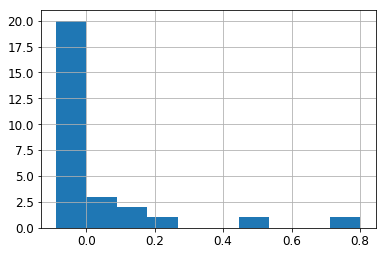

In [17]:
def cluster_similarity(centroids, cluster_words, verbose='none'):
    import numpy as np
    import pandas as pd
    from scipy import spatial
    sim_df = pd.DataFrame(columns=['c1','c2','similarity','c1_words','c2_words'])
    k = 0
    for i in range(len(centroids)):
        c1 = centroids[i]
        for j in range(len(centroids)):
            c2 = centroids[j]
            sim = 1 - spatial.distance.cosine(c1, c2)
            if i < j:
                c1_words = cluster_words[i]
                c2_words = cluster_words[j]
                sim_df.loc[k] = [i, j, sim, c1_words, c2_words]
                k += 1
    sim_df[['c1','c2']] = sim_df[['c1','c2']].astype(int)
    sorted_df = sim_df.sort_values(by=['similarity','c1','c2'], ascending=[False,True,True]) # \
    return sim_df, {'clusters_similarity_file': 'none'}

sim_df, res3 = cluster_similarity(centroids, cluster_words, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)

In [18]:
print('Cluster similarities: absolute values > 0.01:')
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 0.01]

Cluster similarities: absolute values > 0.01:


,c1,c2,similarity,c1_words,c2_words
12,1,7,0.800625,"[fin, wing]","[feather, scale]"
7,1,2,0.523843,"[fin, wing]","[eagle, herring, parrot, tuna]"
23,4,6,0.212294,[has],[isa]
6,0,7,0.165243,"[bird, extremity, fish]","[feather, scale]"
18,3,4,0.094945,[###LEFT-WALL###],[has]
0,0,1,0.087112,"[bird, extremity, fish]","[fin, wing]"
22,4,5,0.038765,[has],[.]
25,5,6,0.038038,[.],[isa]
17,2,7,-0.088270,"[eagle, herring, parrot, tuna]","[feather, scale]"


**Yes!** We have got a category of nouns - clusters 0,2,7 with similarities 0.8, 0.5, 0.16;  
and a category of verbs - clusters 3,6 with similarity 0.2;  
while period and ###LEFT-WALL### stay separated by similarity treshold 0.1

## 2.3 Final check: does the 8th dimension add value?

,c1,c2,similarity,c1_words,c2_words
6,0,7,0.729455,"[fin, wing]","[feather, scale]"
2,0,3,0.487411,"[fin, wing]","[eagle, herring, parrot, tuna]"
14,2,4,0.212294,[isa],[has]
12,1,7,0.163153,"[bird, extremity, fish]","[feather, scale]"
23,4,6,0.094945,[has],[###LEFT-WALL###]
0,0,1,0.085368,"[fin, wing]","[bird, extremity, fish]"
22,4,5,0.038765,[has],[.]
15,2,5,0.038038,[isa],[.]
21,3,7,-0.079841,"[eagle, herring, parrot, tuna]","[feather, scale]"


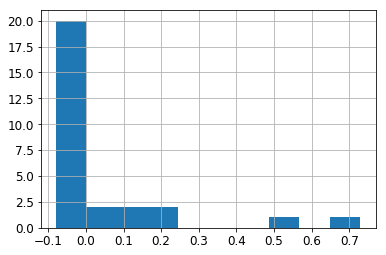

In [19]:
dim = 8
n = 8   # Number of clusters
vdf,res4 = parses2vec(parses,path,tmpath,dim,cds,eig,neg,'none')
words = vdf['word'].tolist()
df = vdf.loc[:,[1,2,3,4,5,6,7,8]]
silhouette, inertia, cluster_labels, centroids, cluster_sizes, \
    cluster_word_ids, cluster_words = cluster_kmeans(n, df, words)
sim_df, res3 = cluster_similarity(centroids, cluster_words, 'max')
count, division = np.histogram(sim_df['similarity'])
sim_df['similarity'].hist(bins=division)
sim_df.sort_values(by='similarity', ascending=False) \
      .loc[abs(sim_df['similarity']) > 0.01]

So, additional 8th dimension can't help us improve clustering quality.
### Singular values help define optimal word space dimensionality.

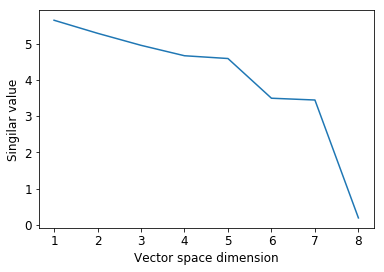

In [20]:
plt.plot(singular_values.index, singular_values['sv'])
plt.xlabel('Vector space dimension')
plt.ylabel('Singilar value')
plt.show()